In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier




In [ ]:
# ================= LOAD DATA =================
train = pd.read_csv("/content/train (3).csv")
test  = pd.read_csv("/content/test (3).csv")

test_ids = test["id"]



In [ ]:
train.head()

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,0,1481.0,Placebo,12963.0,F,N,Y,N,N,2.4,346.0,3.34,70.0,1212.0,122.45,118.0,117.0,12.2,4.0,C
1,1,2580.0,D-penicillamine,20819.0,F,N,N,N,N,0.6,NaN,4.52,51.0,645.0,74.40,NaN,181.0,10.4,3.0,C
2,2,837.0,D-penicillamine,12307.0,F,N,Y,Y,N,6.1,586.0,2.73,89.0,2045.0,196.85,90.0,228.0,10.4,3.0,D
3,3,3021.0,NaN,17532.0,F,NaN,NaN,NaN,N,0.6,NaN,3.34,NaN,NaN,NaN,NaN,388.0,10.4,3.0,C
4,4,1980.0,NaN,23011.0,F,NaN,NaN,NaN,N,0.8,NaN,3.65,NaN,NaN,NaN,NaN,190.0,11.1,4.0,C


In [ ]:
# ================= DATA CLEANING =================
train.fillna(train.median(numeric_only=True), inplace=True)
test.fillna(test.median(numeric_only=True), inplace=True)

for col in train.select_dtypes(include="object"):
    train[col].fillna(train[col].mode()[0], inplace=True)
    if col in test.columns:
        test[col].fillna(test[col].mode()[0], inplace=True)


In [ ]:
# ================= OUTLIER HANDLING =================
num_cols = train.select_dtypes(include=np.number).columns
num_cols = num_cols.drop("id", errors="ignore")

for col in num_cols:
    Q1 = train[col].quantile(0.25)
    Q3 = train[col].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    train[col] = np.where(train[col] < lower, lower, train[col])
    train[col] = np.where(train[col] > upper, upper, train[col])

    if col in test.columns:
        test[col] = np.where(test[col] < lower, lower, test[col])
        test[col] = np.where(test[col] > upper, upper, test[col])



In [ ]:
# ================= TARGET / FEATURES =================
y = train["Status"]
X = train.drop(columns=["Status", "id"], errors="ignore")
test = test.drop(columns=["id"], errors="ignore")

In [ ]:
# ================= ENCODING FEATURES =================
cat_cols = X.select_dtypes(include="object").columns
oe = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)

X[cat_cols] = oe.fit_transform(X[cat_cols])
test[cat_cols] = oe.transform(test[cat_cols])


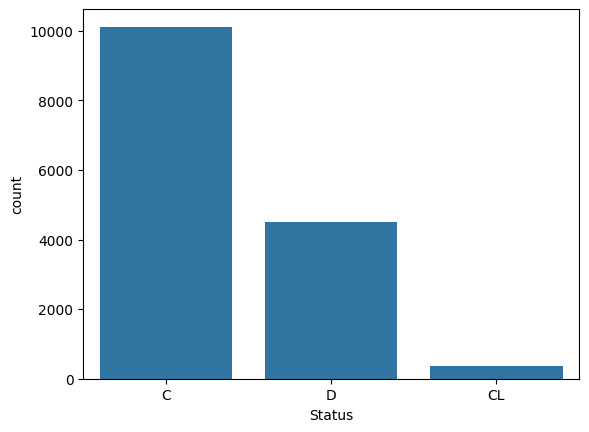

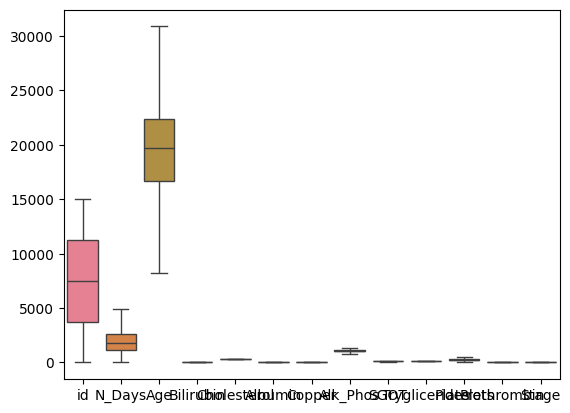

In [ ]:
# ================= EDA =================
sns.countplot(x="Status", data=train)
plt.show()

sns.boxplot(data=train.select_dtypes(include=np.number))
plt.show()

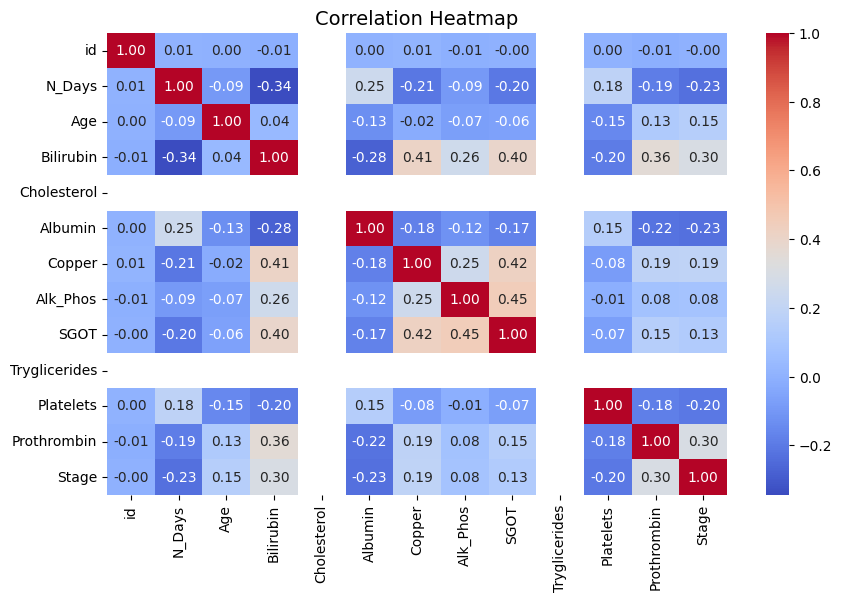

In [ ]:
corr=train.corr(numeric_only=True)
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap", fontsize=14)
plt.show()


In [ ]:
sns.pairplot(train_df,vars = ['Age','Bilirubin','Albumin','Cholesterol','Prothrombin','N_Days'],hue='Status', diag_kind='kde', palette='coolwarm')
plt.suptitle("Pairplot of Features w.r.t. Target (Status)", y=1.02, fontsize=14)
plt.show()

In [ ]:
le = LabelEncoder()
y_enc = le.fit_transform(y)

# ================= ALIGN =================
X, test = X.align(test, axis=1, fill_value=0)




In [ ]:
# ================= SPLIT =================
X_train, X_val, y_train, y_val = train_test_split(
    X, y_enc, test_size=0.2, stratify=y_enc, random_state=42
)

# ================= SCALING (DO NOT OVERWRITE X) =================
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
test_scaled    = scaler.transform(test)

In [ ]:
# ================= LOGISTIC REGRESSION =================
lr = LogisticRegression(max_iter=1000, multi_class="multinomial")
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_val)

print("===== Logistic Regression =====")
print("Accuracy :", accuracy_score(y_val, y_pred_lr))
print("F1 Score :", f1_score(y_val, y_pred_lr, average="macro"))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_lr))


===== Logistic Regression =====
Accuracy : 0.8366666666666667
F1 Score : 0.5513048146391014
Confusion Matrix:
 [[1893    3  127]
 [  51    1   22]
 [ 284    3  616]]


In [ ]:
rf = RandomForestClassifier(random_state=42)

grid = GridSearchCV(
    rf,
    {"n_estimators": [100, 200]},
    cv=3,
    scoring="neg_log_loss"
)

grid.fit(X_train, y_train)

y_pred_rf = grid.best_estimator_.predict(X_val)

print("\n===== Random Forest =====")
print("Accuracy :", accuracy_score(y_val, y_pred_rf))
print("F1 Score :", f1_score(y_val, y_pred_rf, average="macro"))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_rf))


===== Random Forest =====
Accuracy : 0.85
F1 Score : 0.57959177487315
Confusion Matrix:
 [[1899    1  123]
 [  51    3   20]
 [ 253    2  648]]


In [ ]:
# ================= FINAL TRAIN ON FULL DATA =================
grid.best_estimator_.fit(
    scaler.fit_transform(X),
    y_enc
)


RandomForestClassifier(n_estimators=200, random_state=42)

In [ ]:
#lable prediction

In [ ]:
#for multilavel

proba = grid.best_estimator_.predict_proba(test)

submission = pd.DataFrame(proba, columns=le.classes_)
submission.insert(0, "id", test_ids)
submission.to_csv("submission_probabilities.csv", index=False)



#forsingle level

# ================= LABEL PREDICTION =================
y_test_pred = grid.best_estimator_.predict(test)

# Convert encoded labels back to original class names
y_test_pred = le.inverse_transform(y_test_pred)   ##only use when status is given like A,B,C,D  ||| if status is in int dont need to use label encoder

# ================= SUBMISSION =================
submission = pd.DataFrame({
    "id": test_ids,
    "Status": y_test_pred
})

submission.to_csv("submission_labels.csv", index=False)


////


✅ CASE–WISE KAGGLE CLASSIFICATION (NORMAL & CLEAR)
🔹 CASE 1 — Binary Classification (LABEL)
How TARGET looks (train data)
Target
0
1
0
1


or

Yes / No

Metric
Accuracy / F1

Use
predict()

Submission format
id,Target
101,0
102,1

Code
y_test_pred = grid.best_estimator_.predict(test)

submission = pd.DataFrame({
    "id": test_ids,
    "Target": y_test_pred
})

submission.to_csv("submission.csv", index=False)

🔹 CASE 2 — Binary Classification (PROBABILITY)
How TARGET looks
Target
0
1

Metric
Log Loss / AUC

Use
predict_proba()[:,1]

Submission format
id,probability
101,0.87
102,0.12

Code
proba = grid.best_estimator_.predict_proba(test)[:, 1]

submission = pd.DataFrame({
    "id": test_ids,
    "probability": proba
})

submission.to_csv("submission.csv", index=False)

🔹 CASE 3 — Multiclass Classification (LABEL)
How TARGET looks
Status
A
B
C

Metric
Accuracy / Macro-F1

Use
predict()
(+ inverse_transform)

Submission format
id,Status
101,A
102,C
103,B

Code
y_test_pred = grid.best_estimator_.predict(test)

# ONLY because Status = A,B,C
y_test_pred = le.inverse_transform(y_test_pred)

submission = pd.DataFrame({
    "id": test_ids,
    "Status": y_test_pred
})

submission.to_csv("submission.csv", index=False)

🔹 CASE 4 — Multiclass Classification (PROBABILITY)
How TARGET looks
Status
A
B
C

Metric
Multiclass Log Loss

Use
predict_proba()

Submission format
id,A,B,C
101,0.12,0.70,0.18

Code
proba = grid.best_estimator_.predict_proba(test)

submission = pd.DataFrame(proba, columns=le.classes_)
submission.insert(0, "id", test_ids)

submission.to_csv("submission_probabilities.csv", index=False)

🔹 CASE 5 — Multiclass Probability (FIXED NAMES)
How TARGET looks
Status
1
2
3

Metric
Multiclass Log Loss

Use
predict_proba()

Submission format
id,Class_1,Class_2,Class_3
101,0.10,0.60,0.30

Code
proba = grid.best_estimator_.predict_proba(test)

submission = pd.DataFrame(
    proba,
    columns=["Class_1", "Class_2", "Class_3"]
)
submission.insert(0, "id", test_ids)

submission.to_csv("submission.csv", index=False)

🔹 CASE 6 — Multilabel Classification
How TARGET looks
toxic  insult  threat
1      0       1
0      1       0

Metric
Log Loss

Use
predict_proba()

Submission format
id,toxic,insult,threat
101,0.80,0.60,0.10

Code
proba = grid.best_estimator_.predict_proba(test)

submission = pd.DataFrame(
    np.column_stack([p[:, 1] for p in proba]),
    columns=["toxic", "insult", "threat"]
)

submission.insert(0, "id", test_ids)
submission.to_csv("submission.csv", index=False)

🔹 CASE 7 — Target Already Numeric (NO LabelEncoder)
How TARGET looks
Status
0
1
2

Metric
Accuracy / F1

Use
predict()

Submission format
id,Status
101,0
102,2

Code
y_test_pred = grid.best_estimator_.predict(test)

submission = pd.DataFrame({
    "id": test_ids,
    "Status": y_test_pred
})

submission.to_csv("submission.csv", index=False)



/////


✅ CASE–WISE KAGGLE CLASSIFICATION (NORMAL & CLEAR)
🔹 CASE 1 — Binary Classification (LABEL)
How TARGET looks (train data)
Target
0
1
0
1


or

Yes / No

Metric
Accuracy / F1

Use
predict()

Submission format
id,Target
101,0
102,1

Code
y_test_pred = grid.best_estimator_.predict(test)

submission = pd.DataFrame({
    "id": test_ids,
    "Target": y_test_pred
})

submission.to_csv("submission.csv", index=False)

🔹 CASE 2 — Binary Classification (PROBABILITY)
How TARGET looks
Target
0
1

Metric
Log Loss / AUC

Use
predict_proba()[:,1]

Submission format
id,probability
101,0.87
102,0.12

Code
proba = grid.best_estimator_.predict_proba(test)[:, 1]

submission = pd.DataFrame({
    "id": test_ids,
    "probability": proba
})

submission.to_csv("submission.csv", index=False)

🔹 CASE 3 — Multiclass Classification (LABEL)
How TARGET looks
Status
A
B
C

Metric
Accuracy / Macro-F1

Use
predict()
(+ inverse_transform)

Submission format
id,Status
101,A
102,C
103,B

Code
y_test_pred = grid.best_estimator_.predict(test)

# ONLY because Status = A,B,C
y_test_pred = le.inverse_transform(y_test_pred)

submission = pd.DataFrame({
    "id": test_ids,
    "Status": y_test_pred
})

submission.to_csv("submission.csv", index=False)

🔹 CASE 4 — Multiclass Classification (PROBABILITY)
How TARGET looks
Status
A
B
C

Metric
Multiclass Log Loss

Use
predict_proba()

Submission format
id,A,B,C
101,0.12,0.70,0.18

Code
proba = grid.best_estimator_.predict_proba(test)

submission = pd.DataFrame(proba, columns=le.classes_)
submission.insert(0, "id", test_ids)

submission.to_csv("submission_probabilities.csv", index=False)

🔹 CASE 5 — Multiclass Probability (FIXED NAMES)
How TARGET looks
Status
1
2
3

Metric
Multiclass Log Loss

Use
predict_proba()

Submission format
id,Class_1,Class_2,Class_3
101,0.10,0.60,0.30

Code
proba = grid.best_estimator_.predict_proba(test)

submission = pd.DataFrame(
    proba,
    columns=["Class_1", "Class_2", "Class_3"]
)
submission.insert(0, "id", test_ids)

submission.to_csv("submission.csv", index=False)

🔹 CASE 6 — Multilabel Classification
How TARGET looks
toxic  insult  threat
1      0       1
0      1       0

Metric
Log Loss

Use
predict_proba()

Submission format
id,toxic,insult,threat
101,0.80,0.60,0.10

Code
proba = grid.best_estimator_.predict_proba(test)

submission = pd.DataFrame(
    np.column_stack([p[:, 1] for p in proba]),
    columns=["toxic", "insult", "threat"]
)

submission.insert(0, "id", test_ids)
submission.to_csv("submission.csv", index=False)

🔹 CASE 7 — Target Already Numeric (NO LabelEncoder)
How TARGET looks
Status
0
1
2

Metric
Accuracy / F1

Use
predict()

Submission format
id,Status
101,0
102,2

Code
y_test_pred = grid.best_estimator_.predict(test)

submission = pd.DataFrame({
    "id": test_ids,
    "Status": y_test_pred
})

submission.to_csv("submission.csv", index=False)



Assume:

first column = id

remaining columns define submission type

Decision rules:
sample_submission columns	Meaning	What to use
id,Target	label submission	predict()
id,Survived	binary label	predict()
id,probability	binary probability	predict_proba()[:,1]
id,Class_1,Class_2,...	multiclass probability	predict_proba()
id,toxic,insult,...	multilabel	predict_proba()

In [ ]:
print(submission)

         id      C     CL      D
0     15000  0.920  0.010  0.070
1     15001  0.990  0.005  0.005
2     15002  0.895  0.010  0.095
3     15003  0.205  0.080  0.715
4     15004  0.895  0.005  0.100
...     ...    ...    ...    ...
9995  24995  0.435  0.165  0.400
9996  24996  0.275  0.050  0.675
9997  24997  1.000  0.000  0.000
9998  24998  0.240  0.030  0.730
9999  24999  0.620  0.035  0.345

[10000 rows x 4 columns]
